In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if 'module_path' not in sys.path:
    sys.path.append(module_path)

import numpy as np
import nibabel as nib
import neurolang as nl
from typing import AbstractSet, Callable
from neurolang.regions import *
from neurolang.region_solver import *
from neurolang.symbols_and_types import TypedSymbolTable

%matplotlib inline

### Load a subject's brain imaging data:

In [2]:
subject = '100206'
t1w_path = '../data/%s/T1w/T1w_acpc_dc_restore_brain.nii.gz' % subject
labels_path = '../data/%s/T1w/aparc.a2009s+aseg.nii.gz' % subject
labeled_im = nib.load(labels_path)
t1w_im = nib.load(t1w_path)
type(labeled_im)

nibabel.nifti1.Nifti1Image

### Basic plotting of the subject data:

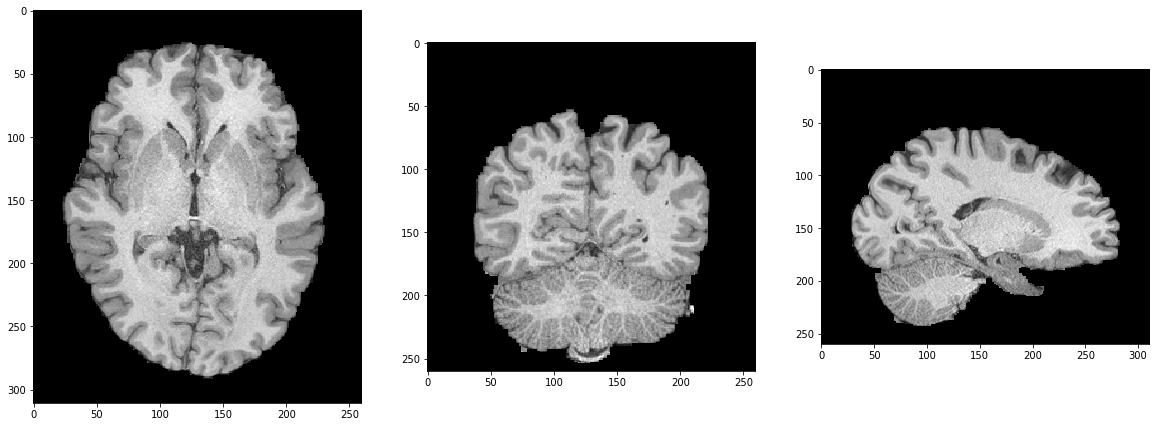

In [3]:
import matplotlib.pyplot as plt
img_data = t1w_im.get_data()

fig = plt.figure(figsize = (20, 20)) 
plt.subplot(1, 3, 1)
plt.imshow(np.rot90(img_data[:,:,100]),cmap = plt.cm.gray,interpolation = 'nearest')
plt.subplot(1, 3, 2)
plt.imshow(np.rot90(img_data[:,100,:]),cmap = plt.cm.gray,interpolation = 'nearest')
plt.subplot(1, 3, 3)
plt.imshow(np.rot90(img_data[100,:,:]),cmap = plt.cm.gray,interpolation = 'nearest')

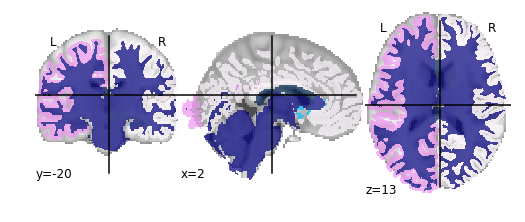

In [4]:
from nilearn import plotting
plotting.plot_roi(labeled_im)

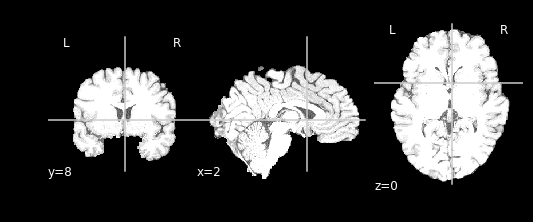

In [5]:
from nilearn.plotting import plot_anat, plot_epi, plot_roi
plot_anat(t1w_im,dim=-1)

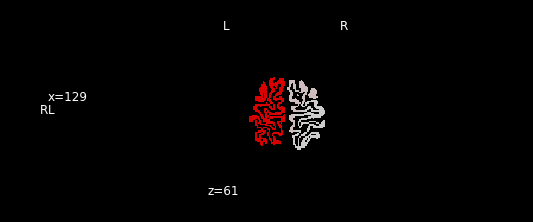

In [6]:
cut_coords = [129, 141, 61]
plot_epi(labeled_im,cut_coords=cut_coords,display_mode='ortho')

### Parse labeled regions from subject:

In [7]:
from xml.etree import ElementTree
extension_header = ElementTree.fromstring(labeled_im.header.extensions[0].get_content())

labeltable = {
    l.text: int(l.get('Key'))
    for l in extension_header.findall(".//Label")
}
labels = labeled_im.get_data()

### Plot a specific region masked over the T1w image:

(array([ 98,  98,  98, ..., 154, 154, 154]), array([149, 149, 149, ..., 149, 150, 151]), array([84, 85, 86, ..., 56, 56, 56]))


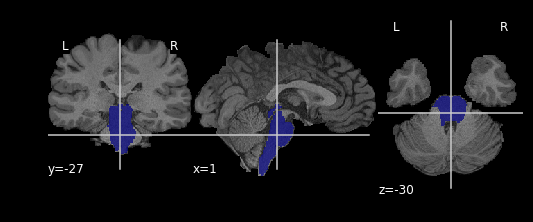

In [8]:
def plot_masked_region_from_voxels(brain_img,voxels, cut_coords=None):
    mask = np.zeros(brain_img.shape)
    for e in voxels:
        mask[tuple(map(int,e))] = 1
    img = nib.Nifti1Image(mask, brain_img.affine)
    plotting.plot_roi(img,brain_img, cut_coords=cut_coords) 

brain_stem_voxels = (labels == labeltable['BRAIN-STEM']).nonzero()

plot_masked_region_from_voxels(t1w_im, zip(*brain_stem_voxels))
print(brain_stem_voxels)

### Define a specific region from a coordinate: 

[[113 138  39]
 [113 138  40]
 [113 138  41]
 ...
 [140 145  42]
 [140 145  43]
 [140 145  44]]


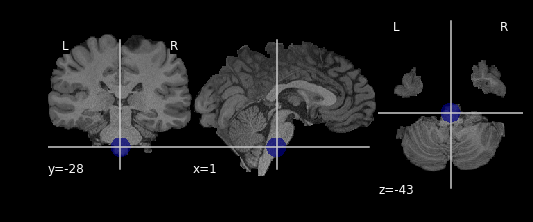

In [9]:
brain_stem_coords = nib.affines.apply_affine(labeled_im.affine, np.transpose(brain_stem_voxels))
center = brain_stem_coords[int(brain_stem_coords.shape[0] / 2)]
radius = 10
sr = SphericalVolume(center, radius)
sphere_voxels = sr.to_ijk(t1w_im.affine)
print(sphere_voxels)
plot_masked_region_from_voxels(t1w_im, sphere_voxels)

### Load labeled regions as symbols into the solver:

In [10]:
set_type = AbstractSet[Region]
region_solver = RegionsSetSolver(TypedSymbolTable())
region_solver.load_regions_to_solver(labeled_im)
regions = [k.name for k, v in region_solver.symbol_table.symbols_by_type(set_type).items()]
len(regions)

192

### Perform a query over regions:

In [11]:
#pairs of (relation, region) that should return empty set:
#anterior_of CTX_RH_G_AND_S_TRANSV_FRONTOPOL
#superior_of CTX_RH_G_AND_S_PARACENTRAL
#inferior_of BRAIN-STEM
obtained = region_solver.run_query('overlapping', 'BRAIN-STEM')
print(len(obtained), obtained)

81 ['LEFT-CEREBRAL-WHITE-MATTER', 'LEFT-LATERAL-VENTRICLE', 'LEFT-INF-LAT-VENT', 'LEFT-CEREBELLUM-WHITE-MATTER', 'LEFT-CEREBELLUM-CORTEX', 'LEFT-THALAMUS-PROPER', 'LEFT-CAUDATE', 'LEFT-PUTAMEN', 'LEFT-PALLIDUM', '3RD-VENTRICLE', '4TH-VENTRICLE', 'LEFT-HIPPOCAMPUS', 'LEFT-AMYGDALA', 'CSF', 'LEFT-VENTRALDC', 'LEFT-VESSEL', 'LEFT-CHOROID-PLEXUS', 'RIGHT-CEREBRAL-WHITE-MATTER', 'RIGHT-LATERAL-VENTRICLE', 'RIGHT-INF-LAT-VENT', 'RIGHT-CEREBELLUM-WHITE-MATTER', 'RIGHT-CEREBELLUM-CORTEX', 'RIGHT-THALAMUS-PROPER', 'RIGHT-CAUDATE', 'RIGHT-PUTAMEN', 'RIGHT-PALLIDUM', 'RIGHT-HIPPOCAMPUS', 'RIGHT-AMYGDALA', 'RIGHT-VENTRALDC', 'RIGHT-CHOROID-PLEXUS', 'WM-HYPOINTENSITIES', 'CTX-LH-UNKNOWN', 'CTX-RH-UNKNOWN', 'CTX_LH_G_CINGUL-POST-VENTRAL', 'CTX_LH_G_FRONT_INF-OPERCULAR', 'CTX_LH_G_FRONT_MIDDLE', 'CTX_LH_G_FRONT_SUP', 'CTX_LH_G_INS_LG_AND_S_CENT_INS', 'CTX_LH_G_INSULAR_SHORT', 'CTX_LH_G_OC-TEMP_LAT-FUSIFOR', 'CTX_LH_G_OC-TEMP_MED-LINGUAL', 'CTX_LH_G_OC-TEMP_MED-PARAHIP', 'CTX_LH_G_TEMP_SUP-G_T_TRANSV'

In [12]:
region_solver.symbol_table[nl.Symbol[region_solver.type]('SPHERE')] = nl.Constant[AbstractSet[region_solver.type]](frozenset([sr]))
obtained = region_solver.run_query('inferior_of', 'SPHERE')
print(len(obtained), obtained)

3 ['LEFT-CEREBELLUM-CORTEX', 'BRAIN-STEM', 'RIGHT-CEREBELLUM-CORTEX']


In [13]:
obtained = region_solver.run_query('inferior_of', 'CTX_LH_G_FRONT_SUP')
print(len(obtained), obtained)

103 ['LEFT-CEREBRAL-WHITE-MATTER', 'LEFT-INF-LAT-VENT', 'LEFT-CEREBELLUM-WHITE-MATTER', 'LEFT-CEREBELLUM-CORTEX', 'LEFT-CAUDATE', 'LEFT-PUTAMEN', 'LEFT-PALLIDUM', '3RD-VENTRICLE', '4TH-VENTRICLE', 'BRAIN-STEM', 'LEFT-HIPPOCAMPUS', 'LEFT-AMYGDALA', 'LEFT-ACCUMBENS-AREA', 'LEFT-VENTRALDC', 'LEFT-VESSEL', 'LEFT-CHOROID-PLEXUS', 'RIGHT-CEREBRAL-WHITE-MATTER', 'RIGHT-LATERAL-VENTRICLE', 'RIGHT-INF-LAT-VENT', 'RIGHT-CEREBELLUM-WHITE-MATTER', 'RIGHT-CEREBELLUM-CORTEX', 'RIGHT-THALAMUS-PROPER', 'RIGHT-CAUDATE', 'RIGHT-PUTAMEN', 'RIGHT-PALLIDUM', 'RIGHT-HIPPOCAMPUS', 'RIGHT-AMYGDALA', 'RIGHT-ACCUMBENS-AREA', 'RIGHT-VENTRALDC', 'RIGHT-VESSEL', 'RIGHT-CHOROID-PLEXUS', 'WM-HYPOINTENSITIES', 'NON-WM-HYPOINTENSITIES', 'OPTIC-CHIASM', 'CTX-LH-UNKNOWN', 'CTX-RH-UNKNOWN', 'CTX_LH_G_AND_S_FRONTOMARGIN', 'CTX_LH_G_AND_S_TRANSV_FRONTOPOL', 'CTX_LH_G_AND_S_CINGUL-ANT', 'CTX_LH_G_FRONT_INF-ORBITAL', 'CTX_LH_G_FRONT_INF-TRIANGUL', 'CTX_LH_G_INS_LG_AND_S_CENT_INS', 'CTX_LH_G_INSULAR_SHORT', 'CTX_LH_G_OC-TEMP_

In [14]:
import time

def measure_time(func):
    t0 = time.time()
    res = func()
    duration = time.time() - t0
    print('Done in %fs' % duration)
    return res

In [15]:
measure_time(lambda : region_solver.run_query('overlapping', 'CTX_LH_G_PARIET_INF-ANGULAR'))

Done in 0.051074s


['LEFT-CEREBRAL-WHITE-MATTER',
 'LEFT-LATERAL-VENTRICLE',
 'LEFT-CHOROID-PLEXUS',
 'RIGHT-CEREBRAL-WHITE-MATTER',
 'RIGHT-CHOROID-PLEXUS',
 'WM-HYPOINTENSITIES',
 'CTX_LH_G_AND_S_PARACENTRAL',
 'CTX_LH_G_CINGUL-POST-VENTRAL',
 'CTX_LH_G_CUNEUS',
 'CTX_LH_G_OCCIPITAL_MIDDLE',
 'CTX_LH_G_OCCIPITAL_SUP',
 'CTX_LH_G_OC-TEMP_MED-LINGUAL',
 'CTX_LH_G_PARIET_INF-SUPRAMAR',
 'CTX_LH_G_PARIETAL_SUP',
 'CTX_LH_G_POSTCENTRAL',
 'CTX_LH_G_PRECUNEUS',
 'CTX_LH_G_TEMP_SUP-LATERAL',
 'CTX_LH_G_TEMP_SUP-PLAN_TEMPO',
 'CTX_LH_G_TEMPORAL_MIDDLE',
 'CTX_LH_POLE_OCCIPITAL',
 'CTX_LH_S_CALCARINE',
 'CTX_LH_S_CINGUL-MARGINALIS',
 'CTX_LH_S_INTERM_PRIM-JENSEN',
 'CTX_LH_S_INTRAPARIET_AND_P_TRANS',
 'CTX_LH_S_OC_MIDDLE_AND_LUNATUS',
 'CTX_LH_S_OC_SUP_AND_TRANSVERSAL',
 'CTX_LH_S_OCCIPITAL_ANT',
 'CTX_LH_S_PARIETO_OCCIPITAL',
 'CTX_LH_S_POSTCENTRAL',
 'CTX_LH_S_SUBPARIETAL',
 'CTX_LH_S_TEMPORAL_INF',
 'CTX_LH_S_TEMPORAL_SUP',
 'CTX_RH_G_AND_S_PARACENTRAL',
 'CTX_RH_G_CUNEUS',
 'CTX_RH_G_OCCIPITAL_MIDDLE',
 'CT

In [16]:
vbr = get_singleton_element_from_frozenset(region_solver.symbol_table['CTX_LH_S_PRECENTRAL-SUP-PART'].value)
other_vbr = get_singleton_element_from_frozenset(region_solver.symbol_table['CTX_LH_G_PRECENTRAL'].value)

voxels = set(map(tuple, vbr._voxels))
other_voxels = set(map(tuple, other_vbr._voxels))

print(voxels.intersection(other_voxels))

set()


### Example case for  union of regions 

63647 63647


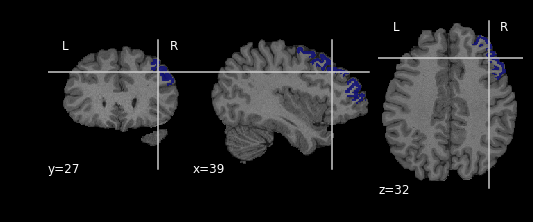

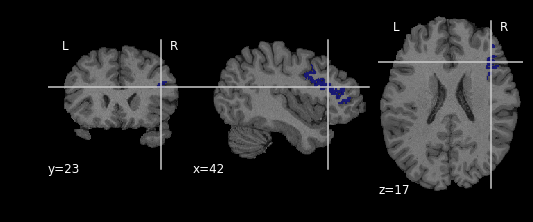

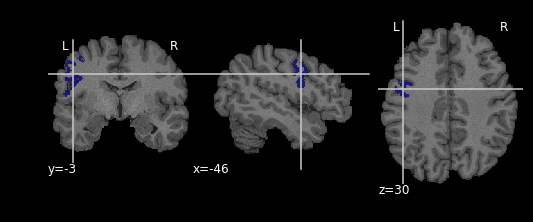

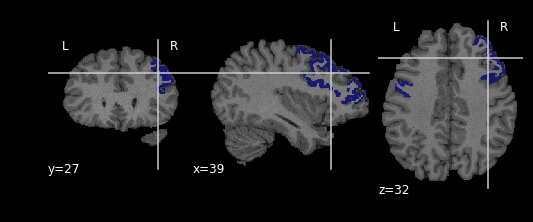

In [18]:
r1 = get_singleton_element_from_frozenset(region_solver.symbol_table['CTX_RH_G_FRONT_MIDDLE'].value)
r2 = get_singleton_element_from_frozenset(region_solver.symbol_table['CTX_RH_S_FRONT_INF'].value)
r3 = get_singleton_element_from_frozenset(region_solver.symbol_table['CTX_LH_S_PRECENTRAL-INF-PART'].value)
fs = set().union([r1, r2, r3])
union = region_union(fs, labeled_im.affine)
print(len(union.to_ijk(labeled_im.affine)), len(r1.to_ijk(labeled_im.affine))+len(r2.to_ijk(labeled_im.affine))+len(r3.to_ijk(labeled_im.affine)))

plot_masked_region_from_voxels(t1w_im, r1._voxels)
plot_masked_region_from_voxels(t1w_im, r2._voxels)
plot_masked_region_from_voxels(t1w_im, r3._voxels)
plot_masked_region_from_voxels(t1w_im, union._voxels, cut_coords=[39, 27, 32])


### Test intersection of regions from set

In [19]:
sphere = get_singleton_element_from_frozenset(region_solver.symbol_table['SPHERE'].value)
brain_stem = get_singleton_element_from_frozenset(region_solver.symbol_table['BRAIN-STEM'].value)
fs = set().union([sphere, brain_stem])
intersect = region_intersection(fs, t1w_im.affine)
print(len(intersect.to_ijk(labeled_im.affine)), len(r1.to_ijk(labeled_im.affine)), len(r2.to_ijk(labeled_im.affine)))


8690 41639 12618


### Brain stem and sphere difference

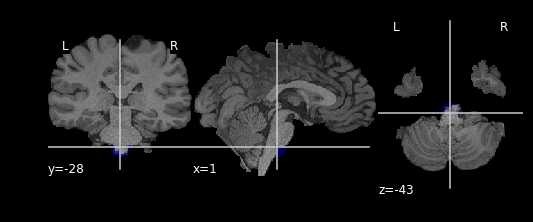

In [20]:
fs = set().union([sphere, brain_stem])
diff = region_difference(fs, t1w_im.affine)
plot_masked_region_from_voxels(t1w_im, diff._voxels, cut_coords=[1, -28, -43])

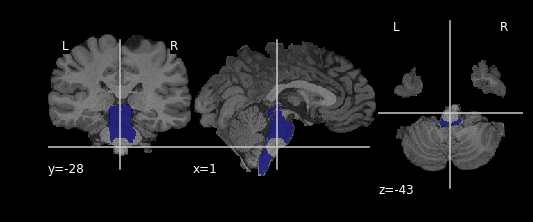

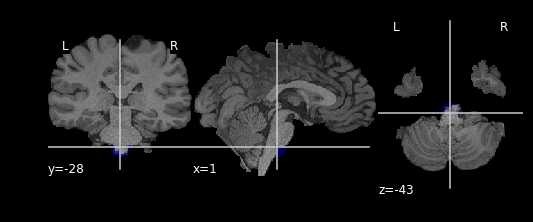

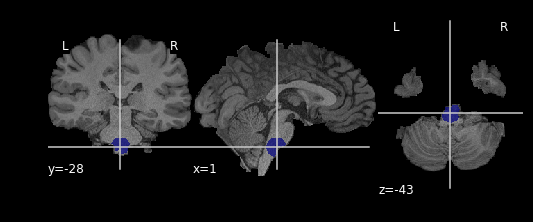

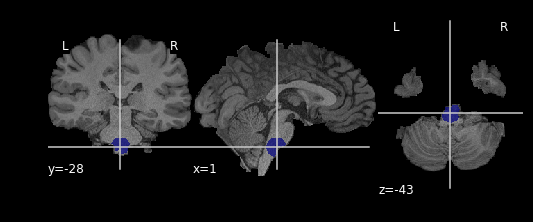

In [21]:
d1 = region_difference([brain_stem, sphere], t1w_im.affine)
d2 = region_difference([sphere, brain_stem], t1w_im.affine)
union = region_union([brain_stem, sphere], t1w_im.affine)
i1 = region_difference([union, d1, d2], t1w_im.affine)
i2 = region_intersection([sphere, brain_stem], t1w_im.affine)

plot_masked_region_from_voxels(t1w_im, d1._voxels, cut_coords=[1, -28, -43])

plot_masked_region_from_voxels(t1w_im, d2._voxels, cut_coords=[1, -28, -43])

plot_masked_region_from_voxels(t1w_im, i1._voxels, cut_coords=[1, -28, -43])

plot_masked_region_from_voxels(t1w_im, i2._voxels, cut_coords=[1, -28, -43])


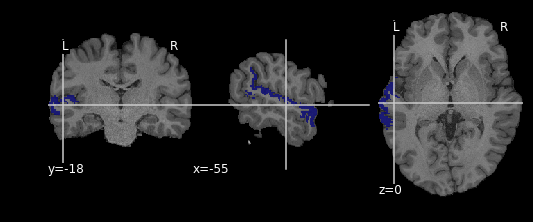

In [22]:
ant_transv_superior_temporal =  get_singleton_element_from_frozenset(region_solver.symbol_table['CTX_LH_G_TEMP_SUP-G_T_TRANSV'].value)
lat_superior_temporal = get_singleton_element_from_frozenset(region_solver.symbol_table['CTX_LH_G_TEMP_SUP-LATERAL'].value)
planum_polare_superior_temporal =  get_singleton_element_from_frozenset(region_solver.symbol_table['CTX_LH_G_TEMP_SUP-PLAN_POLAR'].value)
temp_plane_superior_temporal = get_singleton_element_from_frozenset(region_solver.symbol_table['CTX_LH_G_TEMP_SUP-PLAN_TEMPO'].value)

fs = set().union([ant_transv_superior_temporal, lat_superior_temporal, planum_polare_superior_temporal, temp_plane_superior_temporal])
diff = region_union(fs, t1w_im.affine)
plot_masked_region_from_voxels(t1w_im, diff._voxels)

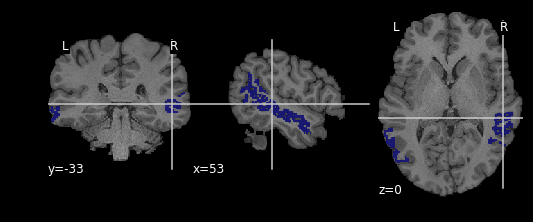

In [24]:
superior_temporal =  get_singleton_element_from_frozenset(region_solver.symbol_table['CTX_RH_S_TEMPORAL_SUP'].value)
obtained = region_solver.run_query('overlapping', 'CTX_RH_S_TEMPORAL_SUP', 'rh_ovrelap_limit_temp_sup')
rh_overlap_limit_temp_sup =  get_singleton_element_from_frozenset(region_solver.symbol_table['rh_ovrelap_limit_temp_sup'].value)
fs = set().union([superior_temporal, rh_overlap_limit_temp_sup])
union = region_union(fs, t1w_im.affine)
plot_masked_region_from_voxels(t1w_im, union.to_ijk(t1w_im.affine))